# Model Inference and Evaluation
This notebook loads the trained ConvLSTM model and evaluates it on the test dataset from the `data` directory.

In [5]:
# Import necessary libraries
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
import os
import cv2
import numpy as np
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Import model
from models.EncoderDecoderCLSTM import EncoderDecoderCLSTM

print("Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

Libraries imported successfully!
PyTorch version: 2.9.0+cu130
CUDA available: True
CUDA device: NVIDIA GeForce RTX 4060 Laptop GPU


In [2]:
# Dataset class for the test data
class TestVideoDataset(Dataset):
    def __init__(self, root_dir, transform=None, sequence_length=30):
        self.root_dir = root_dir
        self.transform = transform
        self.sequence_length = sequence_length
        
        # Get all class folders (0, 1, 2, 3, 4, 5, 6, 7)
        self.class_folders = sorted([f for f in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, f))])
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.class_folders)}
        
        # Build dataset index
        self.video_paths = []
        self.labels = []
        
        for class_folder in self.class_folders:
            class_path = os.path.join(root_dir, class_folder)
            label = self.class_to_idx[class_folder]
            
            # Get all sequence folders for this class
            seq_folders = sorted([s for s in os.listdir(class_path) if s.startswith('seq_')])
            
            for seq_folder in seq_folders:
                seq_path = os.path.join(class_path, seq_folder)
                self.video_paths.append(seq_path)
                self.labels.append(label)
    
    def __len__(self):
        return len(self.video_paths)
    
    def __getitem__(self, idx):
        video_path = self.video_paths[idx]
        label = self.labels[idx]
        
        # Get all frame files in the sequence folder
        frame_files = sorted([f for f in os.listdir(video_path) if f.endswith('.jpg')])
        
        frames = []
        for frame_file in frame_files:
            frame_path = os.path.join(video_path, frame_file)
            
            # Load image
            frame = cv2.imread(frame_path)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            
            # Apply transforms if provided
            if self.transform:
                frame = self.transform(frame)
            else:
                frame = torch.from_numpy(frame).permute(2, 0, 1).float() / 255.0
            
            frames.append(frame)
        
        # Convert to tensor
        video_frames = torch.stack(frames)
        
        # Handle sequence length
        if self.sequence_length is not None:
            if len(video_frames) >= self.sequence_length:
                video_frames = video_frames[:self.sequence_length]
            else:
                padding_needed = self.sequence_length - len(video_frames)
                last_frame = video_frames[-1:]
                padding = last_frame.repeat(padding_needed, 1, 1, 1)
                video_frames = torch.cat([video_frames, padding], dim=0)
        
        return video_frames, label
    
    def get_num_classes(self):
        return len(self.class_folders)

print("Dataset class defined successfully!")

Dataset class defined successfully!


In [6]:
# Setup dataset and dataloader
data_dir = './data'
batch_size = 8
sequence_length = 30

# Define transforms (same as training)
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((128, 128)),
    torchvision.transforms.Normalize(mean=[0.5], std=[0.5])
])

# Create dataset
test_dataset = TestVideoDataset(root_dir=data_dir, transform=transform, sequence_length=sequence_length)
num_classes = test_dataset.get_num_classes()

print(f"Test dataset size: {len(test_dataset)}")
print(f"Number of classes: {num_classes}")
print(f"Batch size: {batch_size}")

# Create dataloader
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
print(f"Number of batches: {len(test_loader)}")

Test dataset size: 400
Number of classes: 8
Batch size: 8
Number of batches: 50


In [ ]:
# Load the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Initialize model
model = EncoderDecoderCLSTM(nf=64, in_chan=3, num_classes=num_classes)

# Load weights
model_path = './ConvLstm_final.pth'
state_dict = torch.load(model_path, map_location=device)

# Handle potential 'model.' prefix in keys
if list(state_dict.keys())[0].startswith('model.'):
    # Remove 'model.' prefix from keys
    new_state_dict = {}
    for key, value in state_dict.items():
        new_key = key.replace('model.', '')
        new_state_dict[new_key] = value
    state_dict = new_state_dict

model.load_state_dict(state_dict)
model = model.to(device)
model.eval()

print("Model loaded successfully!")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

Using device: cuda
Model loaded successfully!
Model parameters: 1,564,778


In [9]:
# Run inference and collect predictions
all_predictions = []
all_labels = []
batch_times = []

print("Running inference on test dataset...")

with torch.no_grad():
    for batch_idx, (videos, labels) in enumerate(tqdm(test_loader, desc="Processing batches")):
        # Move data to device
        videos = videos.to(device)
        labels = labels.to(device)
        
        # Measure batch inference time
        batch_start_time = time.time()
        
        # Forward pass
        outputs = model(videos)
        
        # Record time
        batch_end_time = time.time()
        batch_time = batch_end_time - batch_start_time
        batch_times.append(batch_time)
        
        # Get predictions
        _, predicted = torch.max(outputs.data, 1)
        
        # Store results
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert to numpy arrays
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

print(f"\nInference completed!")
print(f"Total samples processed: {len(all_predictions)}")

Running inference on test dataset...


Processing batches: 100%|██████████| 50/50 [02:57<00:00,  3.56s/it]


Inference completed!
Total samples processed: 400


In [10]:
# Calculate metrics
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions, average='weighted', zero_division=0)
recall = recall_score(all_labels, all_predictions, average='weighted', zero_division=0)
f1 = f1_score(all_labels, all_predictions, average='weighted', zero_division=0)

# Calculate error rate
error_rate = 1 - accuracy

# Calculate timing statistics
avg_batch_time = np.mean(batch_times)
std_batch_time = np.std(batch_times)
min_batch_time = np.min(batch_times)
max_batch_time = np.max(batch_times)
total_inference_time = np.sum(batch_times)

# Print results
print("=" * 60)
print("EVALUATION METRICS")
print("=" * 60)
print(f"\nAccuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Error Rate: {error_rate:.4f} ({error_rate*100:.2f}%)")
print(f"Precision (weighted): {precision:.4f}")
print(f"Recall (weighted): {recall:.4f}")
print(f"F1 Score (weighted): {f1:.4f}")

print("\n" + "=" * 60)
print("INFERENCE TIME STATISTICS")
print("=" * 60)
print(f"\nTotal inference time: {total_inference_time:.4f} seconds")
print(f"Average batch time: {avg_batch_time:.4f} seconds")
print(f"Std batch time: {std_batch_time:.4f} seconds")
print(f"Min batch time: {min_batch_time:.4f} seconds")
print(f"Max batch time: {max_batch_time:.4f} seconds")
print(f"Average time per sample: {avg_batch_time/batch_size:.4f} seconds")
print(f"Throughput: {batch_size/avg_batch_time:.2f} samples/second")

EVALUATION METRICS

Accuracy: 0.1250 (12.50%)
Error Rate: 0.8750 (87.50%)
Precision (weighted): 0.0156
Recall (weighted): 0.1250
F1 Score (weighted): 0.0278

INFERENCE TIME STATISTICS

Total inference time: 2.1351 seconds
Average batch time: 0.0427 seconds
Std batch time: 0.1763 seconds
Min batch time: 0.0140 seconds
Max batch time: 1.2770 seconds
Average time per sample: 0.0053 seconds
Throughput: 187.34 samples/second


In [11]:
# Calculate and display confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

print("\n" + "=" * 60)
print("CONFUSION MATRIX")
print("=" * 60)
print("\nRaw confusion matrix:")
print(cm)

# Calculate per-class metrics
print("\n" + "=" * 60)
print("PER-CLASS METRICS")
print("=" * 60)
print(f"\n{'Class':<10} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<10}")
print("-" * 60)

for i in range(num_classes):
    class_precision = precision_score(all_labels, all_predictions, labels=[i], average='micro', zero_division=0)
    class_recall = recall_score(all_labels, all_predictions, labels=[i], average='micro', zero_division=0)
    class_f1 = f1_score(all_labels, all_predictions, labels=[i], average='micro', zero_division=0)
    class_support = np.sum(all_labels == i)
    
    print(f"{i:<10} {class_precision:<12.4f} {class_recall:<12.4f} {class_f1:<12.4f} {class_support:<10}")

print("=" * 60)


CONFUSION MATRIX

Raw confusion matrix:
[[ 0 50  0  0  0  0  0  0]
 [ 0 50  0  0  0  0  0  0]
 [ 0 50  0  0  0  0  0  0]
 [ 0 50  0  0  0  0  0  0]
 [ 0 50  0  0  0  0  0  0]
 [ 0 50  0  0  0  0  0  0]
 [ 0 50  0  0  0  0  0  0]
 [ 0 50  0  0  0  0  0  0]]

PER-CLASS METRICS

Class      Precision    Recall       F1-Score     Support   
------------------------------------------------------------
0          0.0000       0.0000       0.0000       50        
1          0.1250       1.0000       0.2222       50        
2          0.0000       0.0000       0.0000       50        
3          0.0000       0.0000       0.0000       50        
4          0.0000       0.0000       0.0000       50        
5          0.0000       0.0000       0.0000       50        
6          0.0000       0.0000       0.0000       50        
7          0.0000       0.0000       0.0000       50        


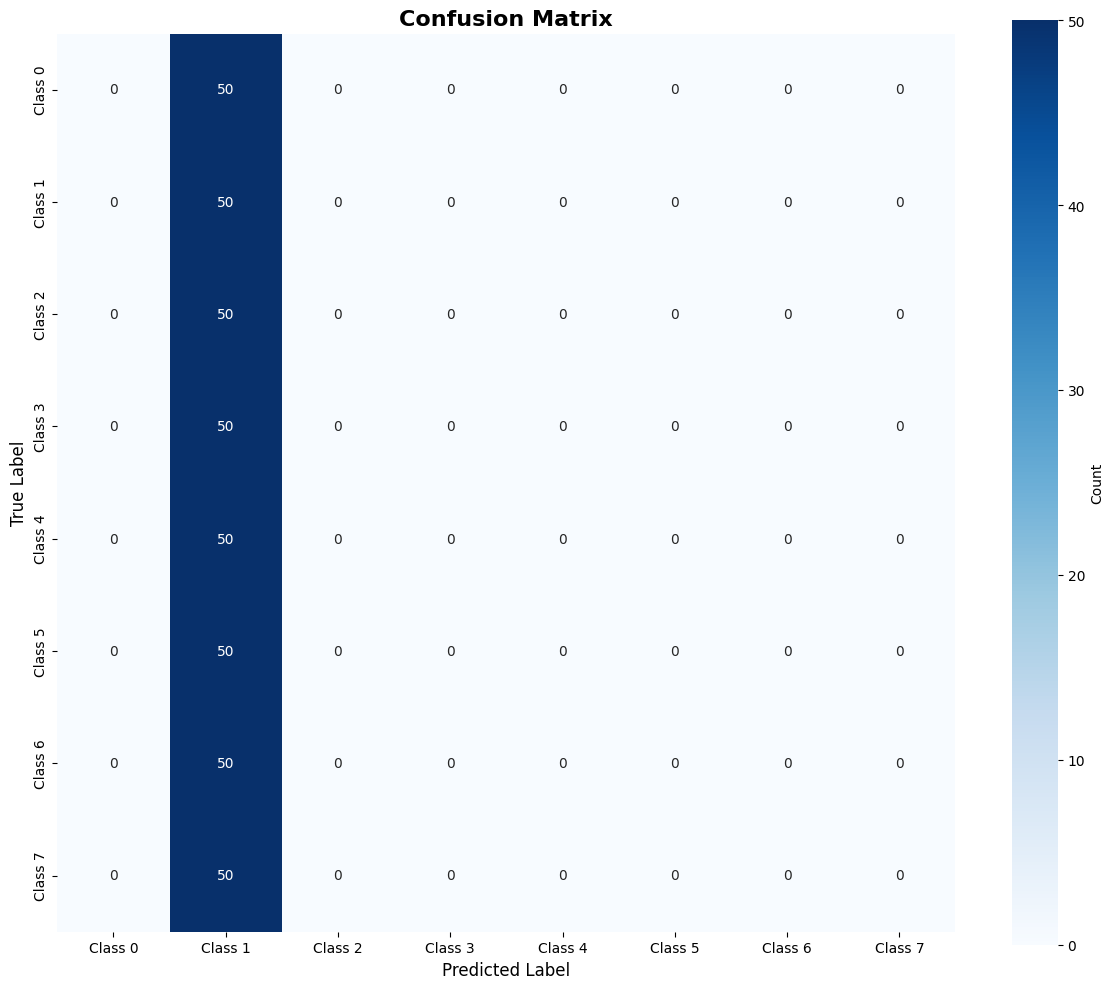

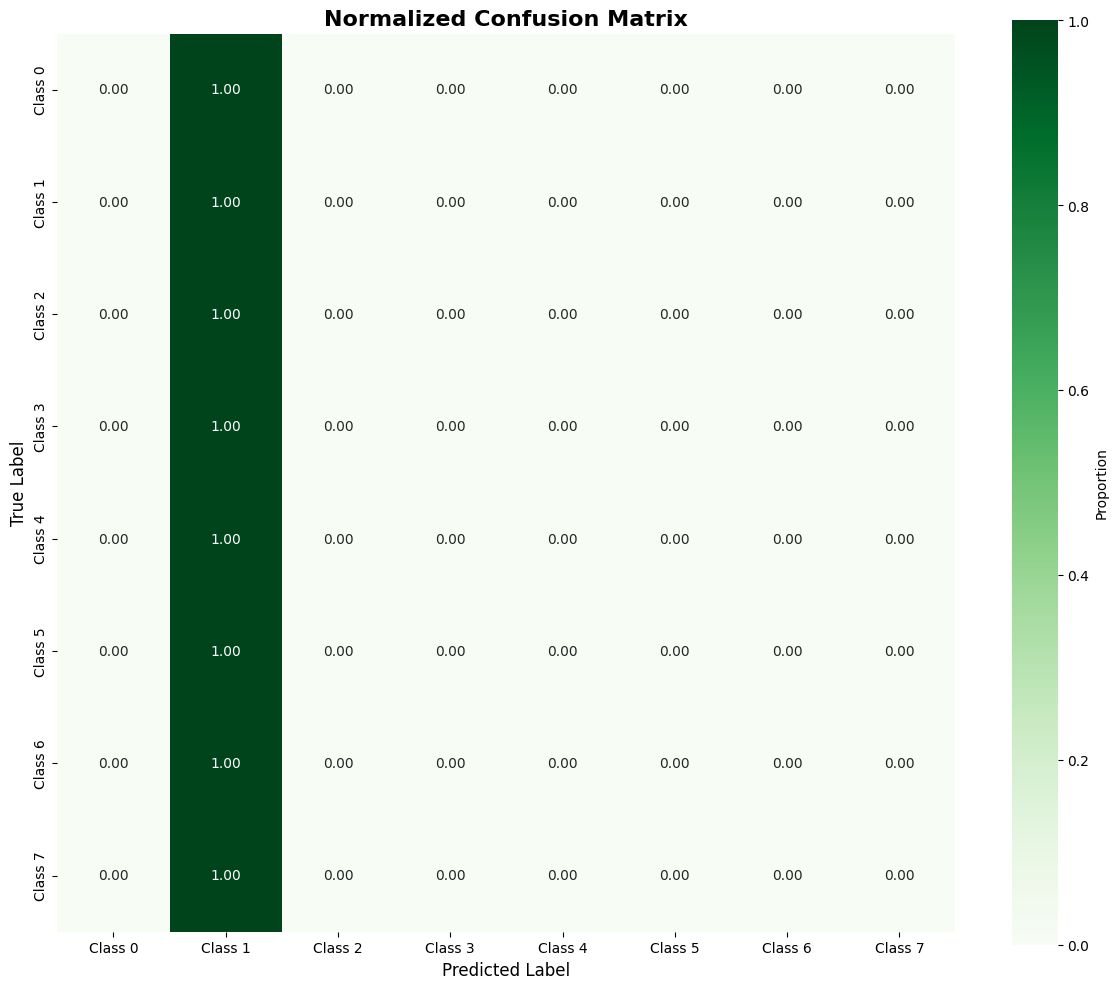

In [12]:
# Visualize confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', square=True, 
            xticklabels=[f'Class {i}' for i in range(num_classes)],
            yticklabels=[f'Class {i}' for i in range(num_classes)],
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

# Visualize normalized confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(12, 10))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Greens', square=True,
            xticklabels=[f'Class {i}' for i in range(num_classes)],
            yticklabels=[f'Class {i}' for i in range(num_classes)],
            cbar_kws={'label': 'Proportion'})
plt.title('Normalized Confusion Matrix', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

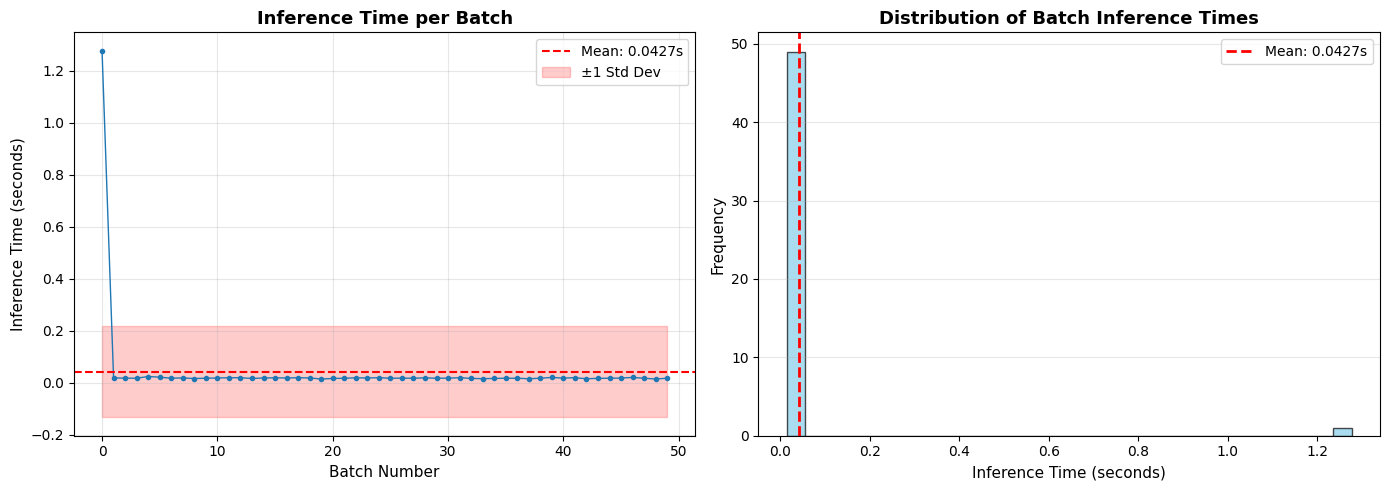

In [13]:
# Visualize batch inference times
plt.figure(figsize=(14, 5))

# Plot 1: Batch times over batches
plt.subplot(1, 2, 1)
plt.plot(batch_times, marker='o', linestyle='-', markersize=3, linewidth=1)
plt.axhline(y=avg_batch_time, color='r', linestyle='--', label=f'Mean: {avg_batch_time:.4f}s')
plt.fill_between(range(len(batch_times)), 
                 avg_batch_time - std_batch_time, 
                 avg_batch_time + std_batch_time, 
                 alpha=0.2, color='red', label=f'±1 Std Dev')
plt.xlabel('Batch Number', fontsize=11)
plt.ylabel('Inference Time (seconds)', fontsize=11)
plt.title('Inference Time per Batch', fontsize=13, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Histogram of batch times
plt.subplot(1, 2, 2)
plt.hist(batch_times, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(x=avg_batch_time, color='r', linestyle='--', linewidth=2, label=f'Mean: {avg_batch_time:.4f}s')
plt.xlabel('Inference Time (seconds)', fontsize=11)
plt.ylabel('Frequency', fontsize=11)
plt.title('Distribution of Batch Inference Times', fontsize=13, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

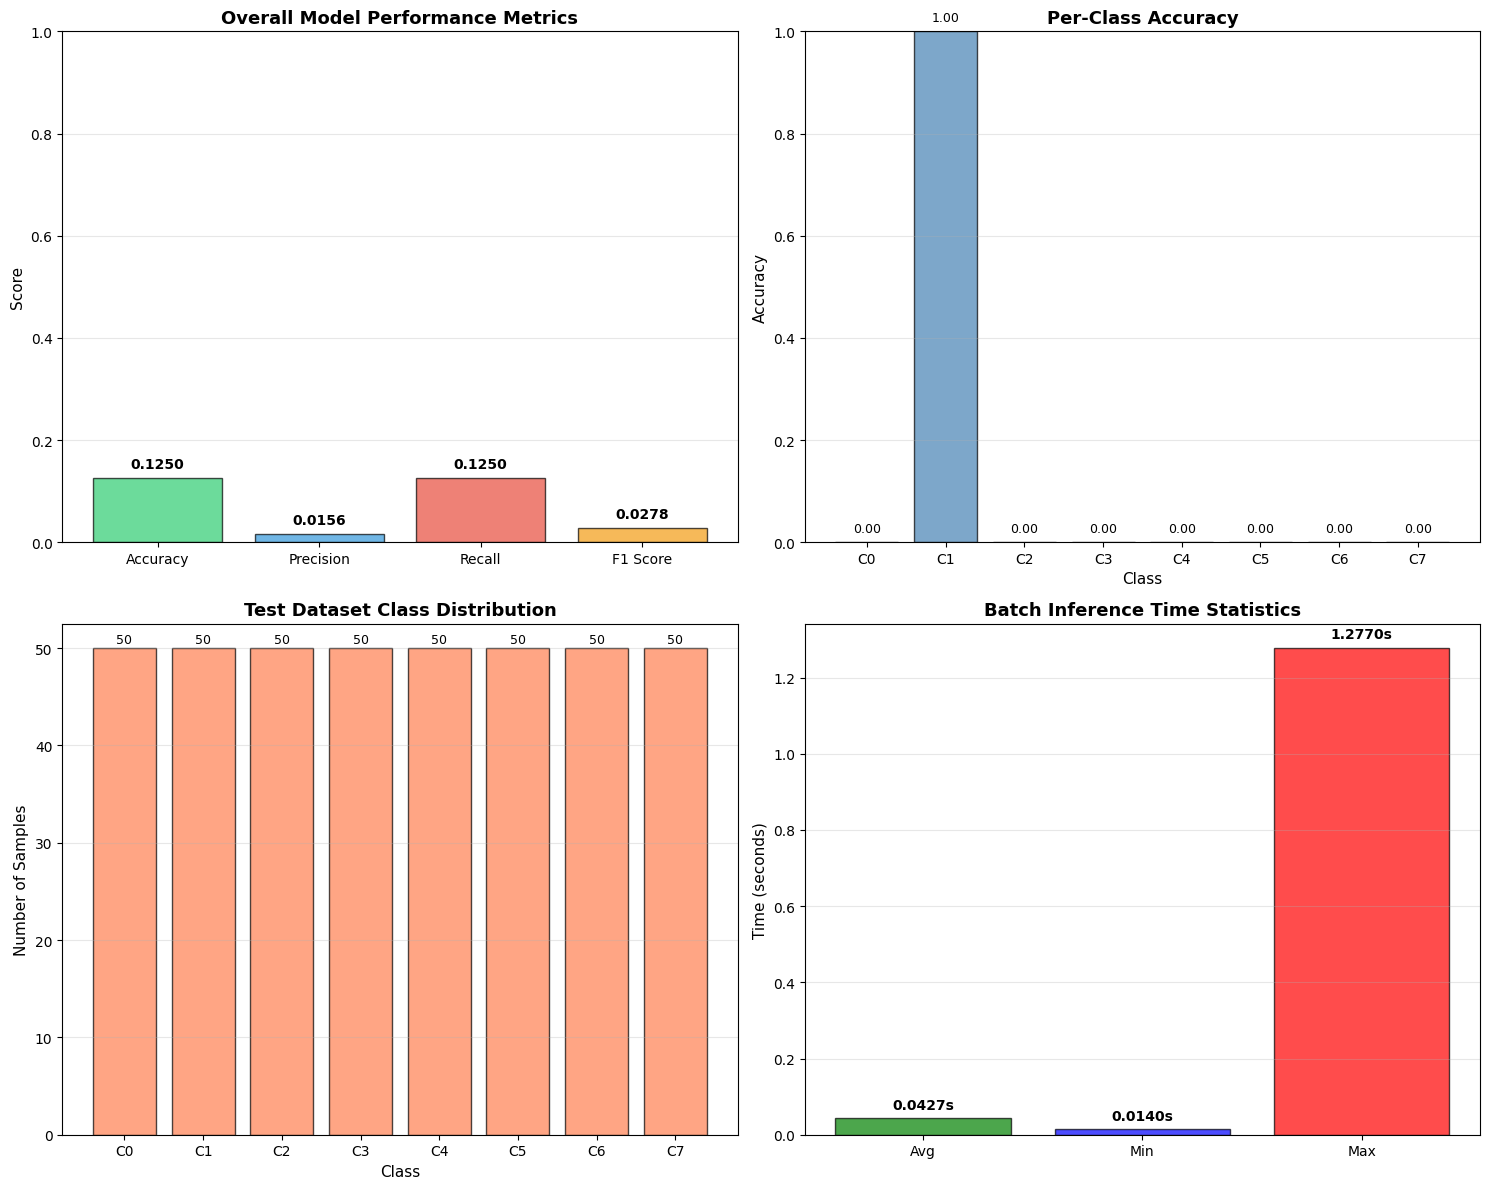

In [14]:
# Summary visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Metrics bar chart
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
metrics_values = [accuracy, precision, recall, f1]
colors = ['#2ecc71', '#3498db', '#e74c3c', '#f39c12']

axes[0, 0].bar(metrics_names, metrics_values, color=colors, alpha=0.7, edgecolor='black')
axes[0, 0].set_ylim([0, 1])
axes[0, 0].set_ylabel('Score', fontsize=11)
axes[0, 0].set_title('Overall Model Performance Metrics', fontsize=13, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3, axis='y')
for i, (name, value) in enumerate(zip(metrics_names, metrics_values)):
    axes[0, 0].text(i, value + 0.02, f'{value:.4f}', ha='center', fontsize=10, fontweight='bold')

# 2. Per-class accuracy
class_accuracies = []
for i in range(num_classes):
    class_mask = all_labels == i
    if np.sum(class_mask) > 0:
        class_acc = np.sum((all_predictions[class_mask] == i)) / np.sum(class_mask)
    else:
        class_acc = 0
    class_accuracies.append(class_acc)

axes[0, 1].bar(range(num_classes), class_accuracies, color='steelblue', alpha=0.7, edgecolor='black')
axes[0, 1].set_xlabel('Class', fontsize=11)
axes[0, 1].set_ylabel('Accuracy', fontsize=11)
axes[0, 1].set_title('Per-Class Accuracy', fontsize=13, fontweight='bold')
axes[0, 1].set_xticks(range(num_classes))
axes[0, 1].set_xticklabels([f'C{i}' for i in range(num_classes)])
axes[0, 1].set_ylim([0, 1])
axes[0, 1].grid(True, alpha=0.3, axis='y')
for i, acc in enumerate(class_accuracies):
    axes[0, 1].text(i, acc + 0.02, f'{acc:.2f}', ha='center', fontsize=9)

# 3. Class distribution
class_counts = [np.sum(all_labels == i) for i in range(num_classes)]
axes[1, 0].bar(range(num_classes), class_counts, color='coral', alpha=0.7, edgecolor='black')
axes[1, 0].set_xlabel('Class', fontsize=11)
axes[1, 0].set_ylabel('Number of Samples', fontsize=11)
axes[1, 0].set_title('Test Dataset Class Distribution', fontsize=13, fontweight='bold')
axes[1, 0].set_xticks(range(num_classes))
axes[1, 0].set_xticklabels([f'C{i}' for i in range(num_classes)])
axes[1, 0].grid(True, alpha=0.3, axis='y')
for i, count in enumerate(class_counts):
    axes[1, 0].text(i, count + 0.5, str(count), ha='center', fontsize=9)

# 4. Timing statistics
timing_labels = ['Avg', 'Min', 'Max']
timing_values = [avg_batch_time, min_batch_time, max_batch_time]
axes[1, 1].bar(timing_labels, timing_values, color=['green', 'blue', 'red'], alpha=0.7, edgecolor='black')
axes[1, 1].set_ylabel('Time (seconds)', fontsize=11)
axes[1, 1].set_title('Batch Inference Time Statistics', fontsize=13, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')
for i, (label, value) in enumerate(zip(timing_labels, timing_values)):
    axes[1, 1].text(i, value + max(timing_values)*0.02, f'{value:.4f}s', ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

## Final Summary

This notebook evaluated the ConvLSTM model on the test dataset and calculated:
- **Accuracy**: Overall correct predictions
- **Error Rate**: 1 - Accuracy
- **Precision**: Weighted average precision across all classes
- **Recall**: Weighted average recall across all classes
- **F1 Score**: Weighted harmonic mean of precision and recall
- **Confusion Matrix**: Both raw counts and normalized proportions
- **Per-Class Metrics**: Individual performance for each class
- **Inference Time**: Average, min, max batch processing times

The visualizations provide insights into model performance, class-wise accuracy, and inference speed.